<a href="https://colab.research.google.com/github/dasaep/W281-ComputerVision-Notebooks/blob/main/Copy_of_understanding_frequencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Understanding Frequencies**: 

1) Watch: run the cell below to see the output of the fourier magnitude and the images.

2) Create: create your own image with a combination of different sinosoidal frequencies and orientations.

3) Separate: Remove certain frequencies from the image. This is done in the frequency domain. Create a circular mask image to block the higher frequencies in Fourier space. 

4) Experiment: Use this mask filter with various radii on the Albert Einstein image. What happens to the image as the mask circle becomes smaller? How does the FFT change with sub-sampling vs blurring?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# create sin images 
def create_sin_grating(f, theta):
    
    # size of the image
    x = np.arange(-128, 129, 1)
    X, Y = np.meshgrid(x, x)
        
    return np.sin(np.pi*f*(X*np.cos(theta) + Y*np.sin(theta)))

# display the fft and the image
def display_fft(in_img, title, log=False):
    
    # fourier image
    [ydim, xdim] = in_img.shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win/np.mean(win)

    # fourier image
    F = np.fft.fftshift(np.fft.fft2(in_img*win))
    Fmag = np.abs(F)
    Fmag[Fmag<0.01] = 0.01
    
    # Display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    # Display image
    axes[0].imshow(in_img, cmap=plt.cm.gray)
    axes[0].set_axis_off()
    axes[0].set_title('image')

    if log:
      axes[1].imshow(np.log(Fmag), cmap=plt.cm.gray)
    else:
      axes[1].imshow(Fmag, cmap=plt.cm.gray)
    axes[1].set_axis_off()
    axes[1].set_title('Fourier Mag')

    plt.suptitle(f'{title}')
    plt.show()
    
    
def create_mask(in_rad, shape):
    
    # create circle mask
    in_mask = np.zeros(shape)
    cy = in_mask.shape[0] // 2
    cx = in_mask.shape[1] // 2
    cv2.circle(in_mask, (cx,cy), in_rad, (255,255,255), -1)[0]
    in_mask = in_mask/255

    # blur the mask
    mask2 = cv2.GaussianBlur(in_mask, (15,15), 10.5, cv2.BORDER_DEFAULT)
    return mask2


def mask_fft(in_img, mask):
            
    F = np.fft.fftshift(np.fft.fft2(in_img))
    Fmag = np.abs(F)*mask
    
    # the ifft assume the incoming fft is shifted to the center of the image
    combined = np.fft.ifftshift(np.multiply(Fmag, np.exp(1j*np.angle(F))))
    imgCombined = np.real(np.fft.ifft2(combined))
    
    return imgCombined

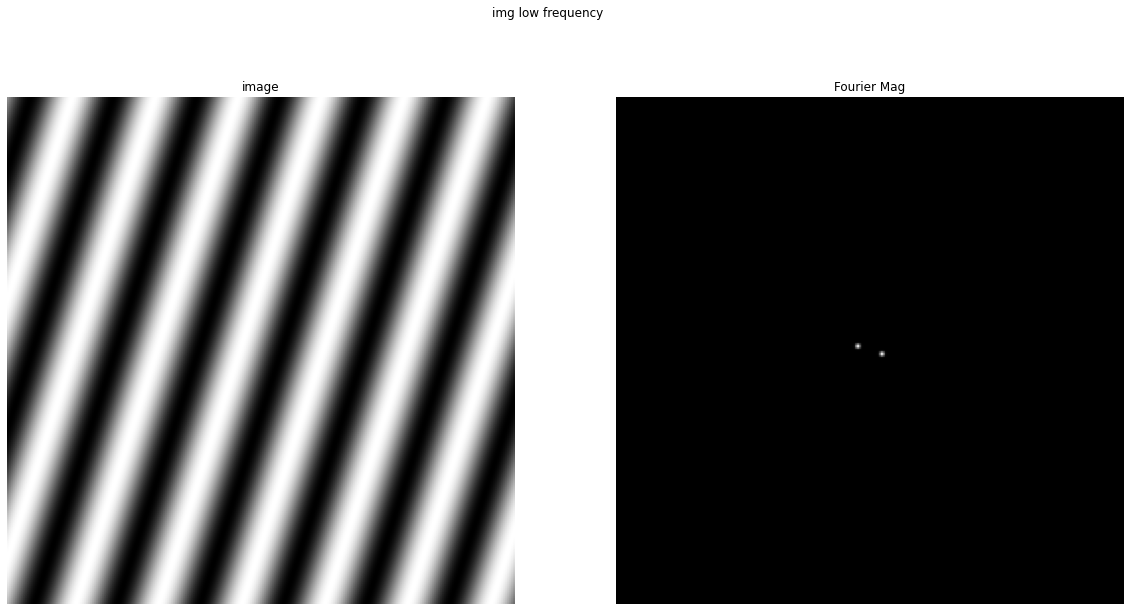

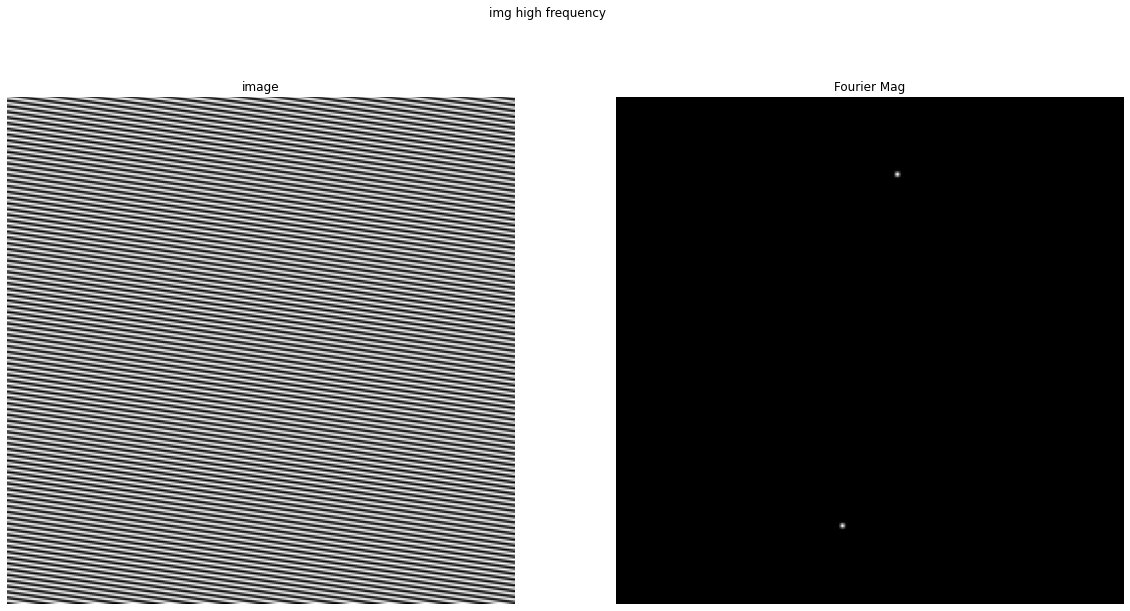

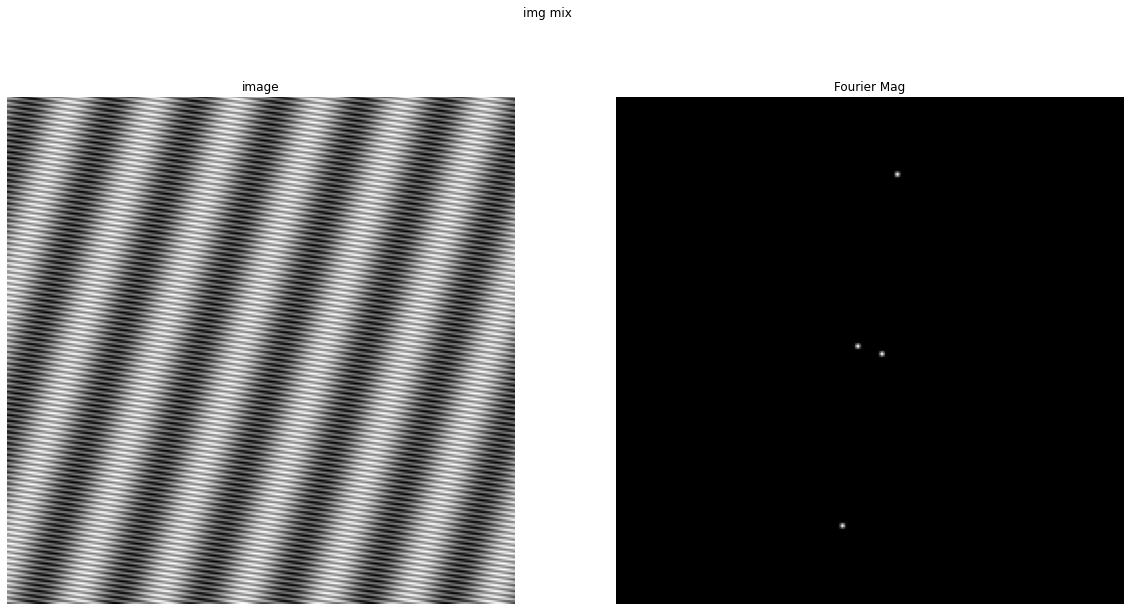

In [ ]:
# Run 

# low frequency image
img1 = create_sin_grating(0.05, (60*np.pi)/180)
display_fft(img1, 'img low frequency')

# high frequency image
img2 = create_sin_grating(0.7, (30*np.pi)/180)
display_fft(img2, 'img high frequency')

# mix
img3 = img1 + img2
display_fft(img3, 'img mix')

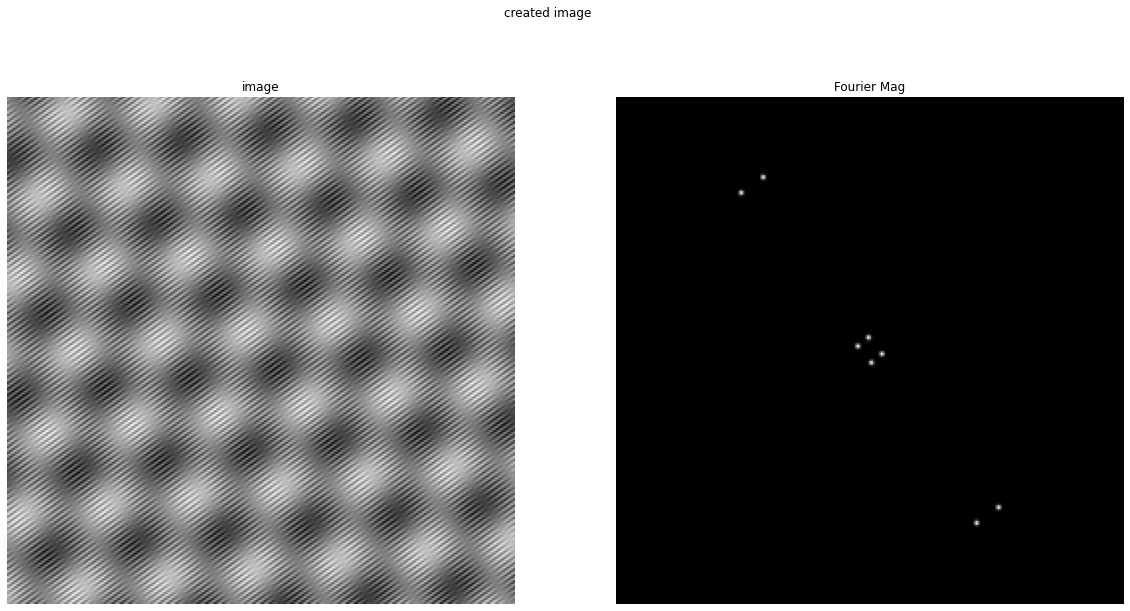

In [ ]:
# Create your own image

# TODO: fill in the frequencies you want in your image
freqs = [0.05, 0.8, 0.8, 0.05]
# TODO: fill in the angles for the frequencies
angles = [80, 45, 70, 60]

img_create = np.zeros((257, 257))
for i in range(len(freqs)):
  img_create = img_create + create_sin_grating(freqs[i], (angles[i]*np.pi)/180)

img_create = img_create/len(freqs)
display_fft(img_create, 'created image')


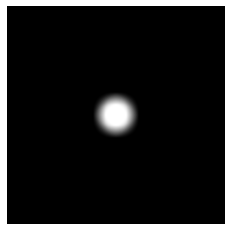

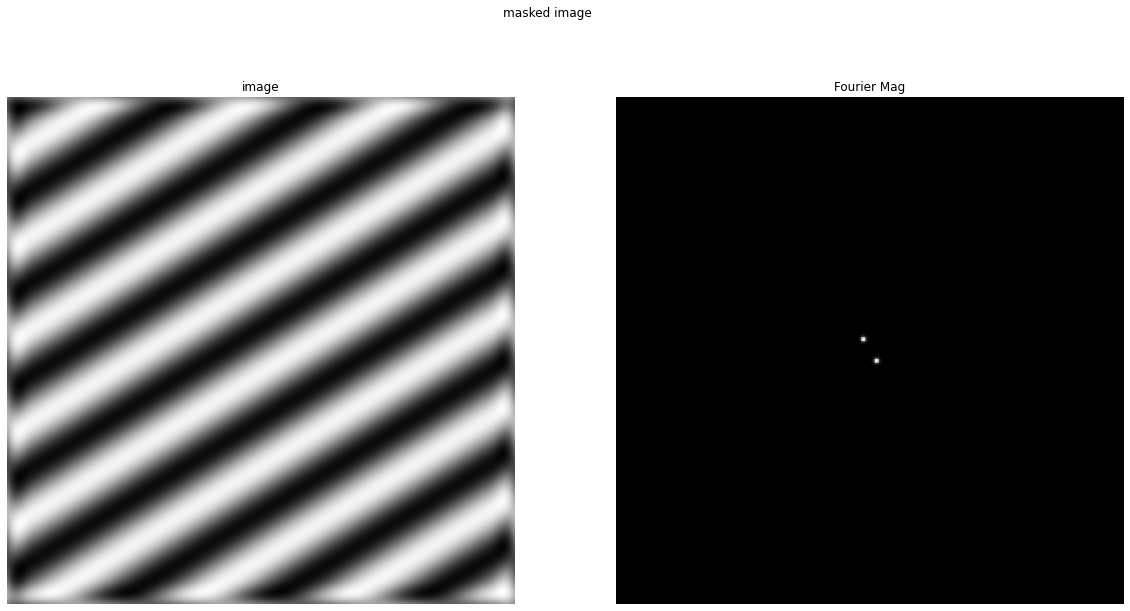

In [ ]:
# separate 
# TODO: change the radius of the mask so that the output image has 
# only low frequency sinosoid 

# create a mask which is 1 in the center portion 
mask  = create_mask(20, img3.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

# mask the fft of the image
masked_image = mask_fft(img3, mask)
display_fft(masked_image, 'masked image')


In [ ]:
from scipy.ndimage import convolve
from scipy import signal

def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d
    

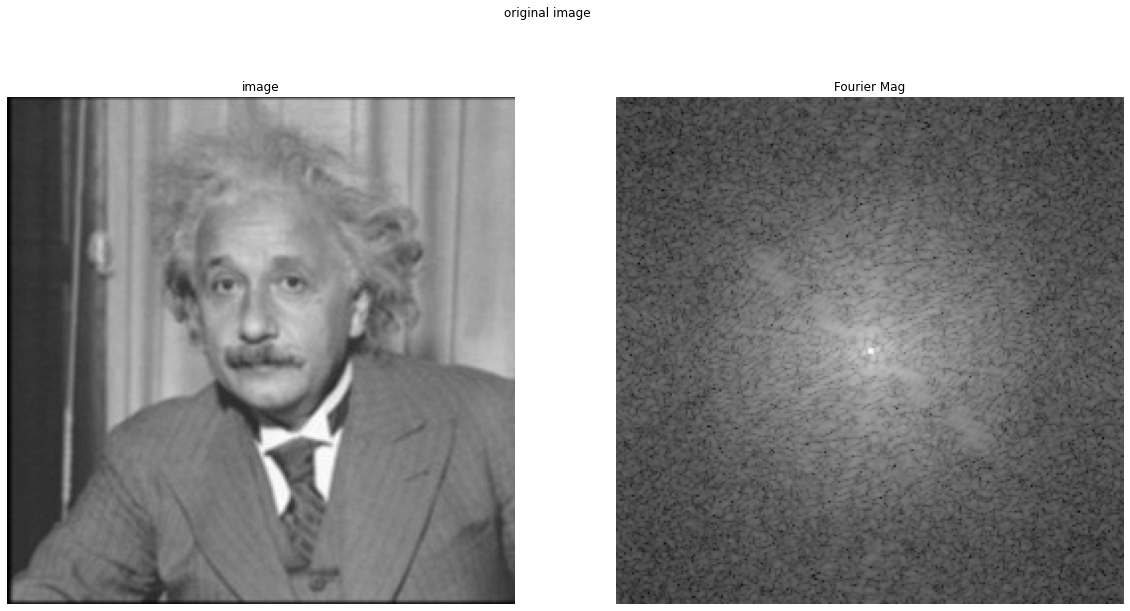

*************************************************************************************************







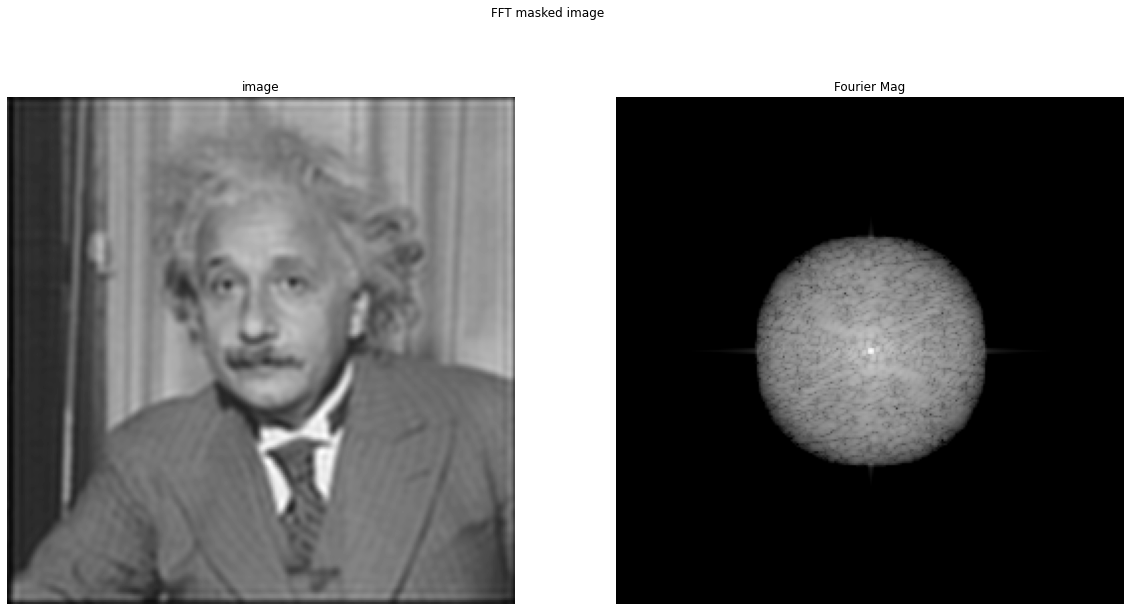

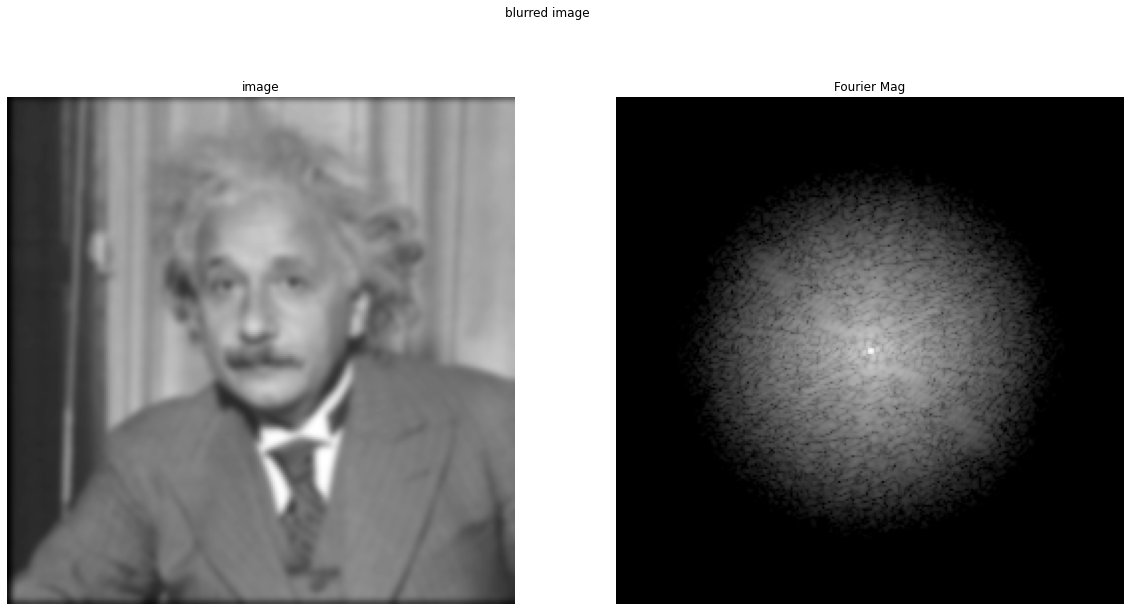

*************************************************************************************************







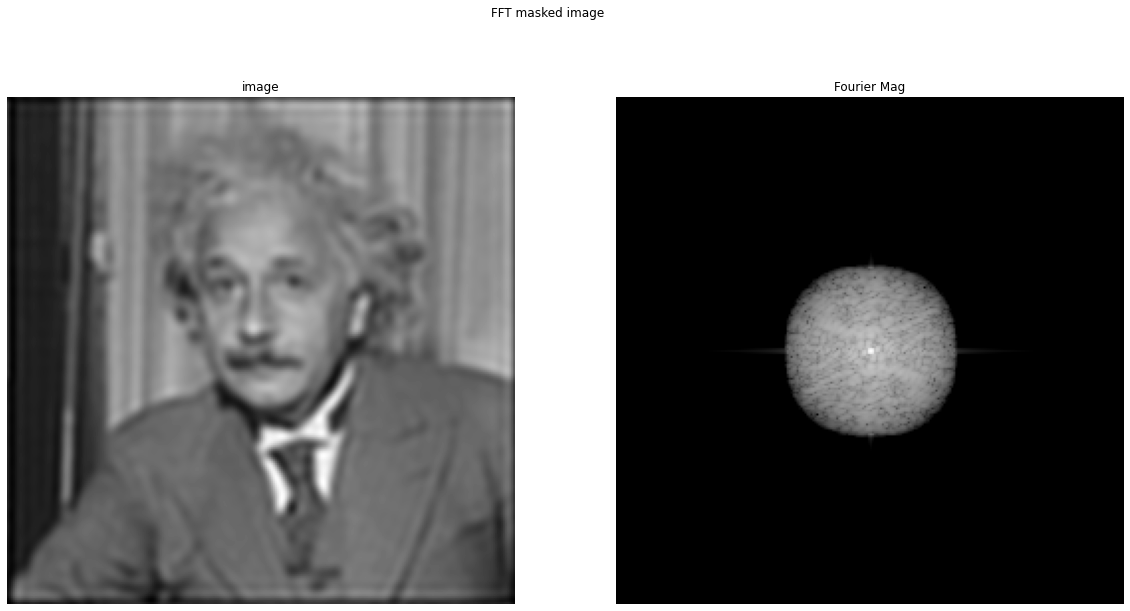

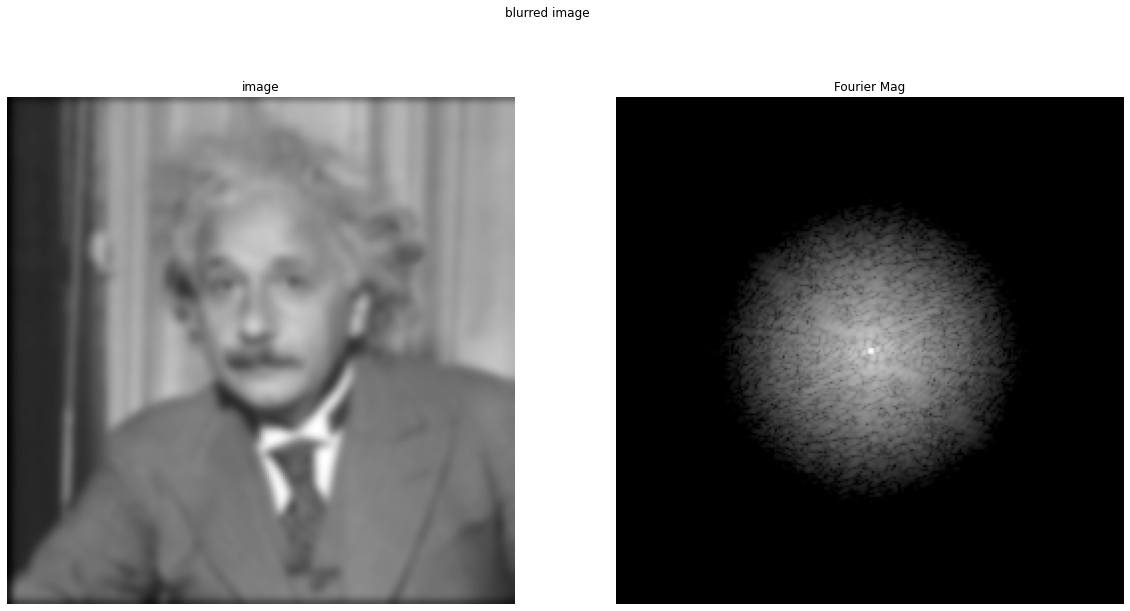

*************************************************************************************************







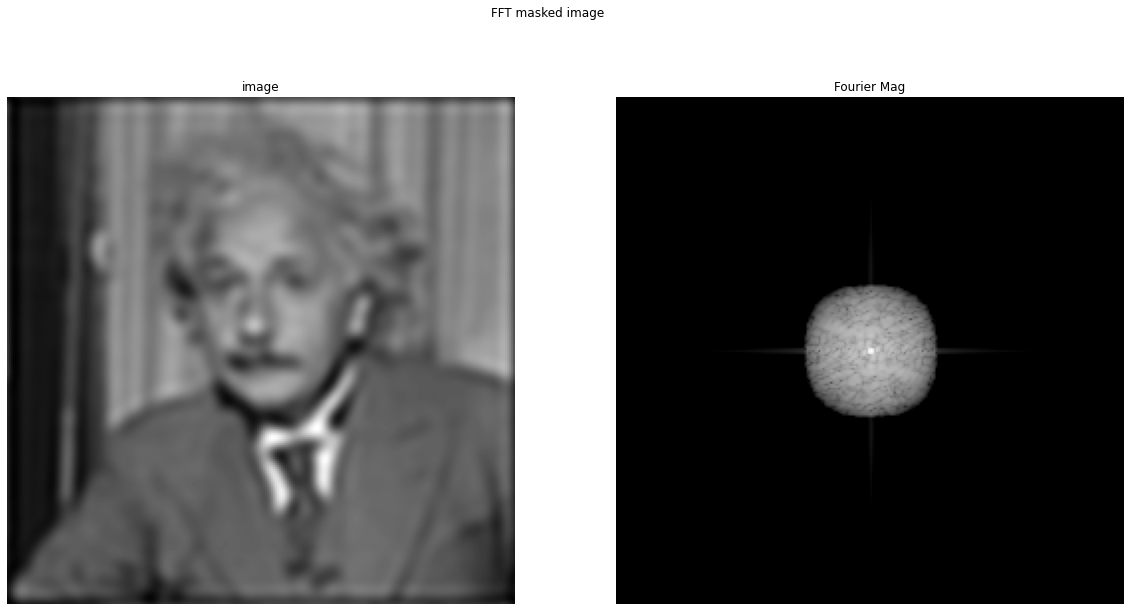

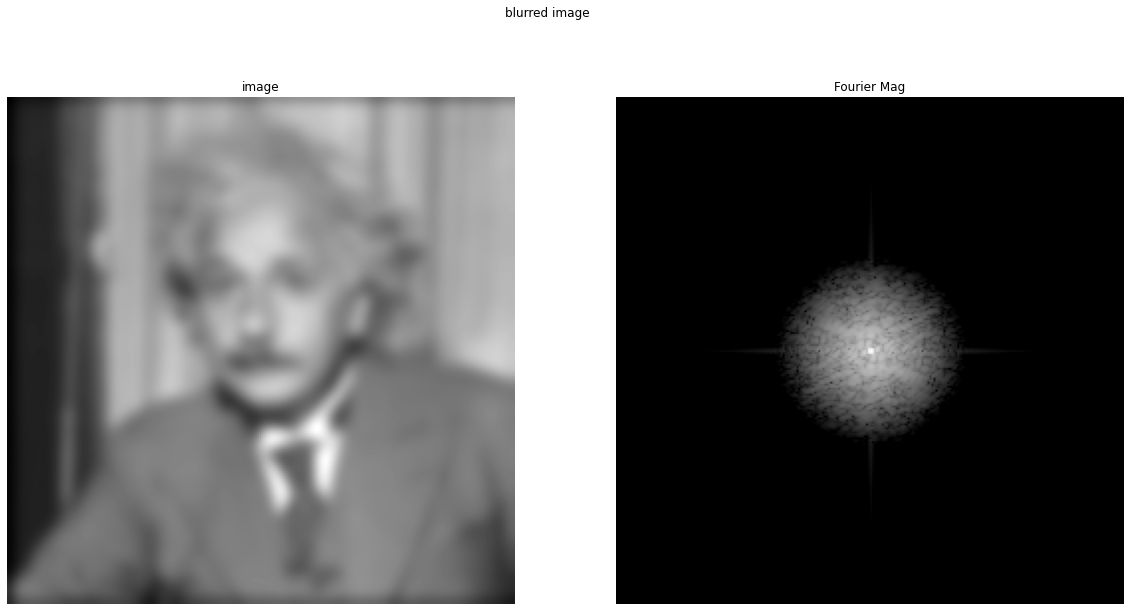

In [ ]:
# experiment with masking vs blurring
al_img = 1.0 * plt.imread("https://raw.githubusercontent.com/W281/fileRepository/main/convolution/al.png") # convert to double
al_img = al_img[:,:,0]
if np.max(al_img)>1:
    al_img = al_img/255.0

display_fft(al_img, 'original image', log=True)

# set Gaussian sigmas and sizes
sigma = [1.5, 2, 3.5]
gsize = [17, 23, 35]

# set FFT mask sizes
ms = [50, 35, 25]

for i in range(len(ms)):

  print('*************************************************************************************************\n\n\n\n\n')
  
  # apply mask to FFT of original image
  mask  = create_mask(ms[i], al_img.shape)
  fft_masked_image = mask_fft(al_img, mask)
  
  # apply blur to original image
  gauss = create_2d_gaussian(size=gsize[i], std=sigma[i])
  blur_img = convolve(al_img, gauss, mode='reflect')
  
  # compare resulting images and FFTs
  display_fft(fft_masked_image, 'FFT masked image', log=True)
  display_fft(blur_img, 'blurred image', log=True)

  


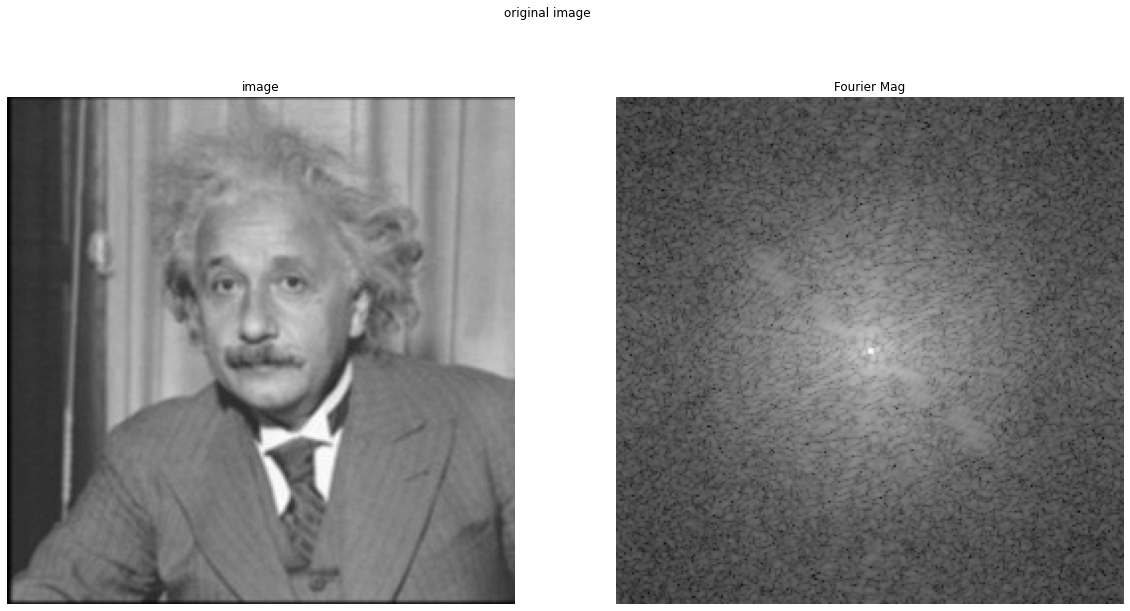

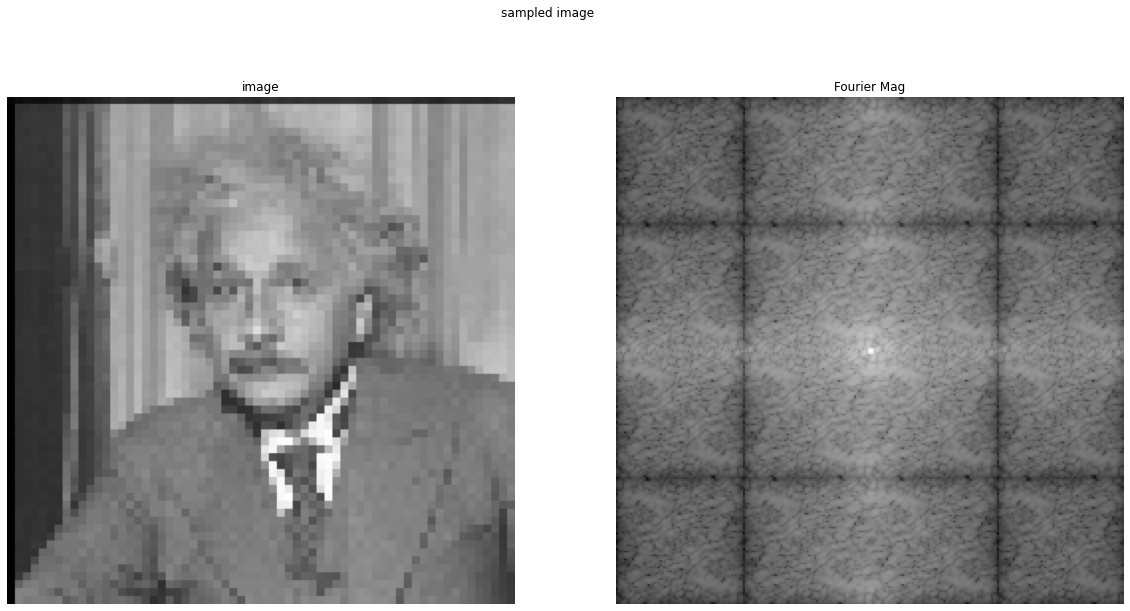

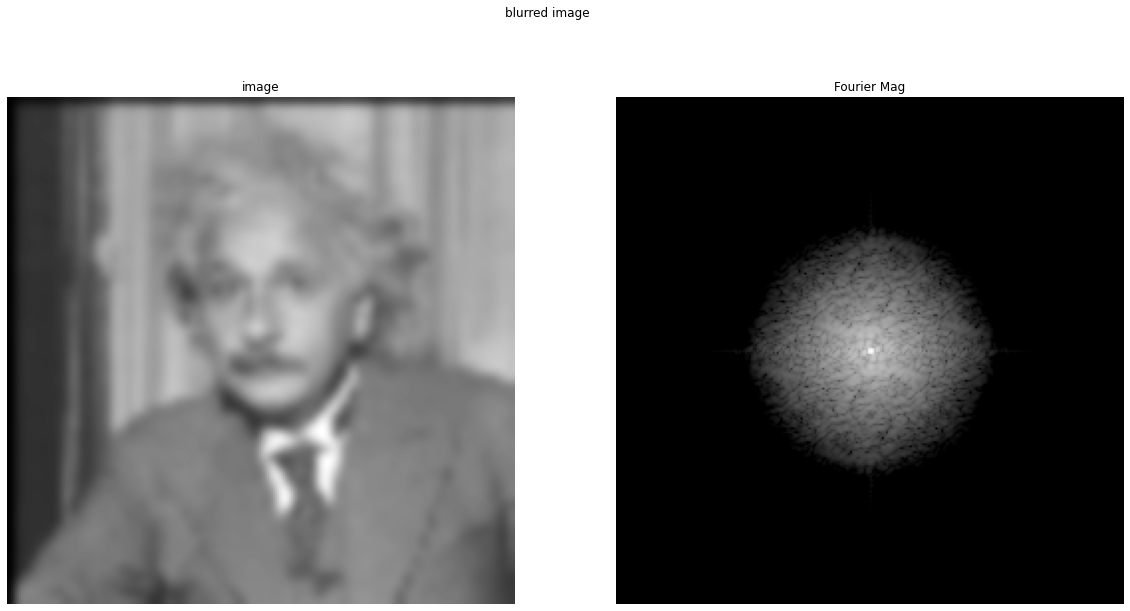

In [ ]:
# experiment with downsampling vs blurring
orig_size = al_img.shape[:2]
new_size = tuple(np.array(orig_size) // 4) # downsample by 4x

# downsample image without interpolation/blurring
sample_img_sm = cv2.resize(al_img, new_size, interpolation=cv2.INTER_NEAREST)
# upsample image back to original size
sample_img = cv2.resize(sample_img_sm, orig_size, interpolation=cv2.INTER_NEAREST)

# blur the image by an equivalent amount
gauss = create_2d_gaussian(size=21, std=2.5)
blur_img = convolve(sample_img, gauss, mode='reflect')

# show the original compared to downsampled and blurred
display_fft(al_img, 'original image', log=True)
display_fft(sample_img, 'sampled image', log=True)
display_fft(blur_img, 'blurred image', log=True)